In [182]:
drive_path = 'd:/'
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_rel
from scipy.stats import variation
from scipy import signal
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
from scipy.stats import fligner
import matplotlib.pyplot as plt
%matplotlib inline
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.natural_scenes import NaturalScenes
import seaborn
import h5py
# import glob
# import time as tm

manifest_path = os.path.join(drive_path,'BrainObservatory','manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_path)
expMetaData = pd.DataFrame(boc.get_ophys_experiments())
cells = pd.DataFrame.from_records(boc.get_cell_specimens())

In [2]:
expMetaData.head()

,age_days,cre_line,experiment_container_id,id,imaging_depth,session_type,targeted_structure
0,132.0,Cux2-CreERT2,511510753,502066273,175,three_session_C,VISpm
1,116.0,Rorb-IRES2-Cre,511511001,506278598,275,three_session_B,VISpm
2,97.0,Rbp4-Cre,511510653,510529677,375,three_session_A,VISpm
3,116.0,Rorb-IRES2-Cre,511510729,504614224,275,three_session_C,VISl
4,123.0,Rorb-IRES2-Cre,511507144,501724959,275,three_session_A,VISp


## Variability (Annie)

In [364]:
# relevCells.head()

In [365]:
# sTabl.shape

In [9]:
# variability_NS = pd.DataFrame(columns = ['std_all','std_VISp','std_VISpm','std_VISl','std_VISal','std_Cux2',
                                            'std_Rorb','std_Rbp4','std_Scnn1a'],
                         index = ['std'])

for expType in range(9):
    stim_STDs = []
    if expType == 0:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B')]
        print("three_session_B")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 1:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISp')]
        print("three_session_B and VISp")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 2:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISpm')]
        print("three_session_B and VISpm")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 3:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISl')]
        print("three_session_B and VISl")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 4:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISal')]
        print("three_session_B and VISal")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 5:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Cux2-CreERT2')]
        print("three_session_B and Cux2")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 6:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rorb-IRES2-Cre')]
        print("three_session_B and Rorb")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 7:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rbp4-Cre')]
        print("three_session_B and Rbp4")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 8:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]
        print("three_session_B and Scnn1a")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])

    for expInd in currSess_metaData.index:
        expContainerID = currSess_metaData.experiment_container_id[expInd]
        expID = currSess_metaData.id[expInd]
        exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
        _, dF = exp.get_dff_traces()
        path = r'D:\BrainObservatory\ophys_analysis\%d_%s_analysis.h5' % (expID, currSess_metaData.session_type[expInd])
        sResp = pd.read_hdf(path, 'analysis/sweep_response_ns')
        sResp_mean = pd.read_hdf(path, 'analysis/mean_sweep_response_ns')
        sTabl = pd.read_hdf(path, 'analysis/stim_table_ns')
        cellIDs = exp.get_cell_specimen_ids()

        relevCells = cells[cells.experiment_container_id == int(expContainerID)]
        relevCells = relevCells[~np.isnan(relevCells.pref_image_ns)]

        for currCell in relevCells.index:
            cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
            prefNS = relevCells.pref_image_ns[currCell]
#             prefDir = relevCells.pref_dir_dg[currCell]
#             prefTF = relevCells.pref_tf_dg[currCell]
            
            prefNS_mask = sTabl.frame == prefNS

# #             prefTF_mask = sTabl.temporal_frequency == prefTF
# #
            cellResponses = sResp_mean[str(cellInd)][prefNS_mask]# & prefDir_mask]
            stim_STDs.append(np.std(cellResponses))

    if expType == 0:
        variability_NS.std_all.std = stim_STDs
    elif expType == 1:
        variability_NS.std_VISp.std = stim_STDs
    elif expType == 2:
        variability_NS.std_VISpm.std = stim_STDs
    elif expType == 3:
        variability_NS.std_VISl.std = stim_STDs
    elif expType == 4:
        variability_NS.std_VISal.std = stim_STDs
    elif expType == 5:
        variability_NS.std_Cux2.std = stim_STDs
    elif expType == 6:
        variability_NS.std_Rorb.std = stim_STDs
    elif expType == 7:
        variability_NS.std_Rbp4.std = stim_STDs
    elif expType == 8:
        variability_NS.std_Scnn1a.std = stim_STDs
print("Done")

three_session_B
	79 sessions to sort through
three_session_B and VISp
	25 sessions to sort through
three_session_B and VISpm
	21 sessions to sort through
three_session_B and VISl
	16 sessions to sort through
three_session_B and VISal
	17 sessions to sort through
three_session_B and Cux2
	42 sessions to sort through
three_session_B and Rorb
	17 sessions to sort through
three_session_B and Rbp4
	16 sessions to sort through
three_session_B and Scnn1a
	4 sessions to sort through
Done


In [141]:
# import pickle
# vNSall=pd.DataFrame({"NS_all":variability_NS.std_all.std})
# vNSall.to_pickle("vNSall.pkl")

# vNSVISp=pd.DataFrame({"NS_VISp":variability_NS.std_VISp.std})
# vNSVISp.to_pickle("vNSVISp.pkl")

# vNSVISpm=pd.DataFrame({"NS_VISpm":variability_NS.std_VISpm.std})
# vNSVISpm.to_pickle("vNSVISpm.pkl")

# vNSVISl=pd.DataFrame({"NS_VISl":variability_NS.std_VISl.std})
# vNSVISl.to_pickle("vNSVISl.pkl")

# vNSVISal=pd.DataFrame({"NS_VISal":variability_NS.std_VISal.std})
# vNSVISal.to_pickle("vNSVISal.pkl")

# vNSCux2=pd.DataFrame({"NS_Cux2":variability_NS.std_Cux2.std})
# vNSCux2.to_pickle("vNSCux2.pkl")

# vNSRorb=pd.DataFrame({"NS_Rorb":variability_NS.std_Rorb.std})
# vNSRorb.to_pickle("vNSRorb.pkl")

# vNSRbp4=pd.DataFrame({"NS_Rbp4":variability_NS.std_Rbp4.std})
# vNSRbp4.to_pickle("vNSRbp4.pkl")

# vNSScnn1a=pd.DataFrame({"NS_Scnn1a":variability_NS.std_Scnn1a.std})
# vNSScnn1a.to_pickle("vNSScnn1a.pkl")

In [367]:
# NS=pd.read_pickle( "vNSScnn1a.pkl" )
# NS.head()

# Stats

In [180]:
anderson_ksamp([variability_NS.std_VISp.std,variability_NS.std_VISpm.std,variability_NS.std_VISl.std,variability_NS.std_VISal.std])

Anderson_ksampResult(statistic=91.681112078784068, critical_values=array([ 0.49854918,  1.3236709 ,  1.91577682,  2.49304213,  3.24593219]), significance_level=7.793229046789034e-144)

In [181]:
anderson_ksamp([variability_NS.std_Rbp4.std,variability_NS.std_Cux2.std,variability_NS.std_Scnn1a.std,variability_NS.std_Rorb.std])

Anderson_ksampResult(statistic=72.396142572421198, critical_values=array([ 0.49854918,  1.3236709 ,  1.91577682,  2.49304213,  3.24593219]), significance_level=3.5110103490880364e-97)

In [436]:
# KS 2SAMP
vVISp_VISpm=ks_2samp(variability_NS.std_VISp.std,variability_NS.std_VISpm.std)
print ('vVISp_VISpm')
print (vVISp_VISpm)
vVISp_VISl=ks_2samp(variability_NS.std_VISp.std,variability_NS.std_VISl.std)
print('vVISp_VISl')
print(vVISp_VISl)
vVISp_VISal=ks_2samp(variability_NS.std_VISp.std,variability_NS.std_VISal.std)
print('vVISp_VISal')
print(vVISp_VISal)
vVISpm_VISl=ks_2samp(variability_NS.std_VISpm.std,variability_NS.std_VISl.std)
print('vVISpm_VISl')
print(vVISpm_VISl)
vVISpm_VISal=ks_2samp(variability_NS.std_VISpm.std,variability_NS.std_VISal.std)
print('vVISpm_VISal')
print(vVISpm_VISal)
vVISl_VISal=ks_2samp(variability_NS.std_VISl.std,variability_NS.std_VISal.std)
print('vVISl_VISal')
print(vVISl_VISal)

vRbp4_Cux2=ks_2samp(variability_NS.std_Rbp4.std,variability_NS.std_Cux2.std)
print('vRbp4_Cux2')
print(vRbp4_Cux2)
vRbp4_Scnn1a=ks_2samp(variability_NS.std_Rbp4.std,variability_NS.std_Scnn1a.std)
print('vRbp4_Scnn1a')
print(vRbp4_Scnn1a)
vRbp4_Rorb=ks_2samp(variability_NS.std_Rbp4.std,variability_NS.std_Rorb.std)
print('vRbp4_Rorb')
print(vRbp4_Rorb)
vCux2_Scnn1a=ks_2samp(variability_NS.std_Cux2.std,variability_NS.std_Scnn1a.std)
print('vCux2_Scnn1a')
print(vCux2_Scnn1a)
vCux2_Rorb=ks_2samp(variability_NS.std_Cux2.std,variability_NS.std_Rorb.std)
print('vCux2_Rorb')
print(vCux2_Rorb)
vScnn1a_Rorb=ks_2samp(variability_NS.std_Scnn1a.std,variability_NS.std_Rorb.std)
print('vScnn1a_Rorb')
print(vScnn1a_Rorb)

vVISp_VISpm
Ks_2sampResult(statistic=0.12719584876362194, pvalue=1.3315152378667187e-21)
vVISp_VISl
Ks_2sampResult(statistic=0.098134463266388139, pvalue=9.7458991337321856e-15)
vVISp_VISal
Ks_2sampResult(statistic=0.14174596779758586, pvalue=4.3067304474007878e-28)
vVISpm_VISl
Ks_2sampResult(statistic=0.038770591456326886, pvalue=0.056116270510482853)
vVISpm_VISal
Ks_2sampResult(statistic=0.037292711553310487, pvalue=0.087081601627814309)
vVISl_VISal
Ks_2sampResult(statistic=0.06930379213636273, pvalue=1.3840404544291539e-05)
vRbp4_Cux2
Ks_2sampResult(statistic=0.14835313174946002, pvalue=1.2367605064638316e-28)
vRbp4_Scnn1a
Ks_2sampResult(statistic=0.031506138041019177, pvalue=0.6849982346070107)
vRbp4_Rorb
Ks_2sampResult(statistic=0.14128783041414517, pvalue=2.852284244737306e-17)
vCux2_Scnn1a
Ks_2sampResult(statistic=0.16800740686507792, pvalue=2.0032234179713175e-16)
vCux2_Rorb
Ks_2sampResult(statistic=0.044125248793240257, pvalue=0.0038050805542304013)
vScnn1a_Rorb
Ks_2sampResult

In [184]:
fligner(variability_NS.std_VISp.std,variability_NS.std_VISpm.std,variability_NS.std_VISl.std,variability_NS.std_VISal.std)

FlignerResult(statistic=41.925206296840351, pvalue=4.1614634794184887e-09)

In [185]:
fligner(variability_NS.std_Rbp4.std,variability_NS.std_Cux2.std,variability_NS.std_Scnn1a.std,variability_NS.std_Rorb.std)

FlignerResult(statistic=34.920657351290757, pvalue=1.2661890789823885e-07)

# Plots

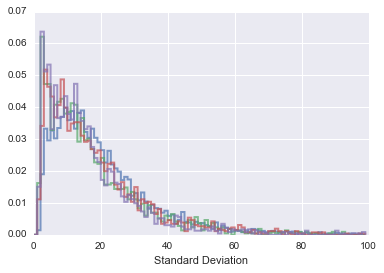

In [444]:
fig,ax = plt.subplots()
ax.hist(variability_NS.std_VISp.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_VISp.std)+1./len(variability_NS.std_VISp.std));
ax.hist(variability_NS.std_VISpm.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_VISpm.std)+1./len(variability_NS.std_VISpm.std));
ax.hist(variability_NS.std_VISl.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_VISl.std)+1./len(variability_NS.std_VISl.std));
ax.hist(variability_NS.std_VISal.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_VISal.std)+1./len(variability_NS.std_VISal.std));

ax.set_xlabel('Standard Deviation')

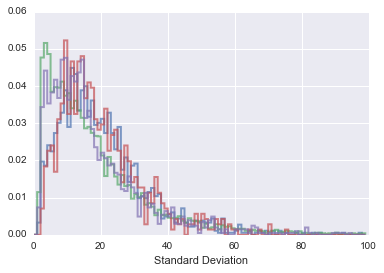

In [443]:
fig,ax = plt.subplots()
ax.hist(variability_NS.std_Rbp4.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_Rbp4.std)+1./len(variability_NS.std_Rbp4.std));
ax.hist(variability_NS.std_Cux2.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_Cux2.std)+1./len(variability_NS.std_Cux2.std));
ax.hist(variability_NS.std_Scnn1a.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_Scnn1a.std)+1./len(variability_NS.std_Scnn1a.std));
ax.hist(variability_NS.std_Rorb.std,bins=np.arange(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(variability_NS.std_Rorb.std)+1./len(variability_NS.std_Rorb.std));

ax.set_xlabel('Standard Deviation')

# Reliability

In [345]:
#reliability_NS = pd.DataFrame(columns = ['r_all','r_VISp','r_VISpm','r_VISl','r_VISal','r_Cux2',
                                            'r_Rorb','r_Rbp4','r_Scnn1a'],
                         index = ['r'])

# osi_dgMax = 1.5
# osi_dgMin = 0
# walkThresh = 1
# runThresh = 5

for expType in range(9):
    stim_reliability = []
    if expType == 0:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B')]
        print("three_session_B")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 1:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISp')]
        print("three_session_B and VISp")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 2:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISpm')]
        print("three_session_B and VISpm")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 3:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISl')]
        print("three_session_B and VISl")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 4:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISal')]
        print("three_session_B and VISal")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 5:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Cux2-CreERT2')]
        print("three_session_B and Cux2")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 6:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rorb-IRES2-Cre')]
        print("three_session_B and Rorb")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 7:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rbp4-Cre')]
        print("three_session_B and Rbp4")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 8:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]
        print("three_session_B and Scnn1a")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])

    for expInd in currSess_metaData.index:
        expContainerID = currSess_metaData.experiment_container_id[expInd]
        expID = currSess_metaData.id[expInd]
        exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
        #_, dF = exp.get_dff_traces()
        path = r'D:\BrainObservatory\ophys_analysis\%d_%s_analysis.h5' % (expID, currSess_metaData.session_type[expInd])
        sReliability = pd.read_hdf(path, 'analysis/peak')
        Reliability=sReliability['response_variability_ns']
        stim_reliability.extend(Reliability.values)

    if expType == 0:
        reliability_NS.r_all.r = stim_reliability
    elif expType == 1:
        reliability_NS.r_VISp.r = stim_reliability
    elif expType == 2:
        reliability_NS.r_VISpm.r = stim_reliability
    elif expType == 3:
        reliability_NS.r_VISl.r = stim_reliability
    elif expType == 4:
        reliability_NS.r_VISal.r = stim_reliability
    elif expType == 5:
        reliability_NS.r_Cux2.r = stim_reliability
    elif expType == 6:
        reliability_NS.r_Rorb.r = stim_reliability
    elif expType == 7:
        reliability_NS.r_Rbp4.r = stim_reliability
    elif expType == 8:
        reliability_NS.r_Scnn1a.r = stim_reliability
print("Done")

three_session_B
	79 sessions to sort through
three_session_B and VISp
	25 sessions to sort through
three_session_B and VISpm
	21 sessions to sort through
three_session_B and VISl
	16 sessions to sort through
three_session_B and VISal
	17 sessions to sort through
three_session_B and Cux2
	42 sessions to sort through
three_session_B and Rorb
	17 sessions to sort through
three_session_B and Rbp4
	16 sessions to sort through
three_session_B and Scnn1a
	4 sessions to sort through
Done


In [407]:
#rNS=np.asarray(reliability_NS.r_VISp.values[0])

In [405]:
#import pickle
rNSall=pd.DataFrame({"R_all":reliability_NS.r_all.r})
rNSall.to_pickle("rNSall.pkl")

rNSVISp=pd.DataFrame({"R_VISp":reliability_NS.r_VISp.r})
rNSVISp.to_pickle("rNSVISp.pkl")

rNSVISpm=pd.DataFrame({"R_VISpm":reliability_NS.r_VISpm.r})
rNSVISpm.to_pickle("rNSVISpm.pkl")

rNSVISl=pd.DataFrame({"R_VISl":reliability_NS.r_VISl.r})
rNSVISl.to_pickle("rNSVISl.pkl")

rNSVISal=pd.DataFrame({"R_VISal":reliability_NS.r_VISal.r})
rNSVISal.to_pickle("rNSVISal.pkl")

rNSCux2=pd.DataFrame({"R_Cux2":reliability_NS.r_Cux2.r})
rNSCux2.to_pickle("rNSCux2.pkl")

rNSRorb=pd.DataFrame({"R_Rorb":reliability_NS.r_Rorb.r})
rNSRorb.to_pickle("rNSRorb.pkl")

rNSRbp4=pd.DataFrame({"R_Rbp4":reliability_NS.r_Rbp4.r})
rNSRbp4.to_pickle("rNSRbp4.pkl")

rNSScnn1a=pd.DataFrame({"R_Scnn1a":reliability_NS.r_Scnn1a.r})
rNSScnn1a.to_pickle("rNSScnn1a.pkl")

In [406]:
NS=pd.read_pickle( "rNSall.pkl" )
NS.head()

,R_all
0,36.0
1,12.0
2,24.0
3,50.0
4,38.0


# Stats

In [411]:
anderson_ksamp([reliability_NS.r_VISp.r,reliability_NS.r_VISpm.r,reliability_NS.r_VISl.r,reliability_NS.r_VISal.r])

Anderson_ksampResult(statistic=325.53051033082835, critical_values=array([ 0.49854918,  1.3236709 ,  1.91577682,  2.49304213,  3.24593219]), significance_level=0.0)

In [438]:
anderson_ksamp([reliability_NS.r_Rbp4.r,reliability_NS.r_Cux2.r,reliability_NS.r_Scnn1a.r,reliability_NS.r_Rorb.r])

Anderson_ksampResult(statistic=25.343905578563515, critical_values=array([ 0.49854918,  1.3236709 ,  1.91577682,  2.49304213,  3.24593219]), significance_level=1.5788647994744197e-20)

In [454]:
# KS 2SAMP
rVISp_VISpm=ks_2samp(reliability_NS.r_VISp.r,reliability_NS.r_VISpm.r)
print('rVISp_VISpm')
print(rVISp_VISpm)
rVISp_VISl=ks_2samp(reliability_NS.r_VISp.r,reliability_NS.r_VISl.r)
print('rVISp_VISl')
print(rVISp_VISl)
rVISp_VISal=ks_2samp(reliability_NS.r_VISp.r,reliability_NS.r_VISal.r)
print('rVISp_VISal')
print(rVISp_VISal)
rVISpm_VISl=ks_2samp(reliability_NS.r_VISpm.r,reliability_NS.r_VISl.r)
print('rVISpm_VISl')
print(rVISpm_VISl)
rVISpm_VISal=ks_2samp(reliability_NS.r_VISpm.r,reliability_NS.r_VISal.r)
print('rVISpm_VISal')
print(rVISpm_VISal)
rVISl_VISal=ks_2samp(reliability_NS.r_VISl.r,reliability_NS.r_VISal.r)
print('rVISl_VISal')
print(rVISl_VISal)

rRbp4_Cux2=ks_2samp(reliability_NS.r_Rbp4.r,reliability_NS.r_Cux2.r)
print('rRbp4_Cux2')
print(rRbp4_Cux2)
rRbp4_Scnn1a=ks_2samp(reliability_NS.r_Rbp4.r,reliability_NS.r_Scnn1a.r)
print('rRbp4_Scnn1a')
print(rRbp4_Scnn1a)
rRbp4_Rorb=ks_2samp(reliability_NS.r_Rbp4.r,reliability_NS.r_Rorb.r)
print('rRbp4_Rorb')
print(rRbp4_Rorb)
rCux2_Scnn1a=ks_2samp(reliability_NS.r_Cux2.r,reliability_NS.r_Scnn1a.r)
print('rCux2_Scnn1a')
print(rCux2_Scnn1a)
rCux2_Rorb=ks_2samp(reliability_NS.r_Cux2.r,reliability_NS.r_Rorb.r)
print('rCux2_Rorb')
print(rCux2_Rorb)
rScnn1a_Rorb=ks_2samp(reliability_NS.r_Scnn1a.r,reliability_NS.r_Rorb.r)
print('rCux2_Rorb')
print(rCux2_Rorb)

rVISp_VISpm
Ks_2sampResult(statistic=0.28150432048081059, pvalue=3.7698603463214289e-104)
rVISp_VISl
Ks_2sampResult(statistic=0.1258372982283858, pvalue=5.8581201713927649e-24)
rVISp_VISal
Ks_2sampResult(statistic=0.23726580735778657, pvalue=6.0514734024709039e-78)
rVISpm_VISl
Ks_2sampResult(statistic=0.15937971323264916, pvalue=1.1882952502080004e-26)
rVISpm_VISal
Ks_2sampResult(statistic=0.062101965170212325, pvalue=0.00033626149286671822)
rVISl_VISal
Ks_2sampResult(statistic=0.11142850912940078, pvalue=9.1660309442771494e-14)
rRbp4_Cux2
Ks_2sampResult(statistic=0.09395425608839697, pvalue=9.7016604140526692e-12)
rRbp4_Scnn1a
Ks_2sampResult(statistic=0.066656158439342805, pvalue=0.020403323269022933)
rRbp4_Rorb
Ks_2sampResult(statistic=0.064985517635860024, pvalue=0.00054601674991208336)
rCux2_Scnn1a
Ks_2sampResult(statistic=0.069610193896352701, pvalue=0.0035848033095793024)
rCux2_Rorb
Ks_2sampResult(statistic=0.029662271451829703, pvalue=0.11789468187217404)
rCux2_Rorb
Ks_2sampResu

# Graphs

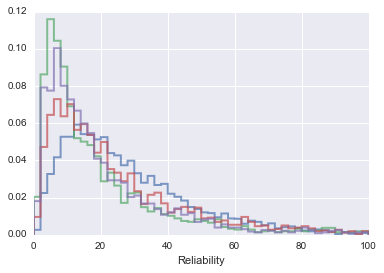

In [477]:
fig,ax = plt.subplots()
ax.hist(reliability_NS.r_VISp.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_VISp.r)+1./len(reliability_NS.r_VISp.r));
ax.hist(reliability_NS.r_VISpm.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_VISpm.r)+1./len(reliability_NS.r_VISpm.r));
ax.hist(reliability_NS.r_VISl.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_VISl.r)+1./len(reliability_NS.r_VISl.r));
ax.hist(reliability_NS.r_VISal.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_VISal.r)+1./len(reliability_NS.r_VISal.r));

ax.set_xlabel('Reliability')

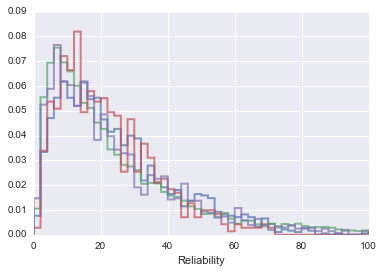

In [478]:
fig,ax = plt.subplots()
ax.hist(reliability_NS.r_Rbp4.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_Rbp4.r)+1./len(reliability_NS.r_Rbp4.r));
ax.hist(reliability_NS.r_Cux2.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_Cux2.r)+1./len(reliability_NS.r_Cux2.r));
ax.hist(reliability_NS.r_Scnn1a.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_Scnn1a.r)+1./len(reliability_NS.r_Scnn1a.r));
ax.hist(reliability_NS.r_Rorb.r,bins=(50),range=(0,100),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(reliability_NS.r_Rorb.r)+1./len(reliability_NS.r_Rorb.r));

ax.set_xlabel('Reliability')

# COV

In [453]:
cov_NS = pd.DataFrame(columns = ['cov_all','cov_VISp','cov_VISpm','cov_VISl','cov_VISal','cov_Cux2',
                                            'cov_Rorb','cov_Rbp4','cov_Scnn1a'],
                         index = ['cov'])

for expType in range(9):
    cov = []
    if expType == 0:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B')]
        print("three_session_B")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 1:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISp')]
        print("three_session_B and VISp")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 2:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISpm')]
        print("three_session_B and VISpm")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 3:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISl')]
        print("three_session_B and VISl")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 4:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.targeted_structure == 'VISal')]
        print("three_session_B and VISal")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 5:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Cux2-CreERT2')]
        print("three_session_B and Cux2")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 6:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rorb-IRES2-Cre')]
        print("three_session_B and Rorb")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 7:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Rbp4-Cre')]
        print("three_session_B and Rbp4")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])
    elif expType == 8:
        currSess_metaData = expMetaData[(expMetaData.session_type == 'three_session_B') & (expMetaData.cre_line == 'Scnn1a-Tg3-Cre')]
        print("three_session_B and Scnn1a")
        print("\t%d sessions to sort through" % currSess_metaData.shape[0])

    for expInd in currSess_metaData.index:
        expContainerID = currSess_metaData.experiment_container_id[expInd]
        expID = currSess_metaData.id[expInd]
        exp = boc.get_ophys_experiment_data(ophys_experiment_id = expID)
        _, dF = exp.get_dff_traces()
        path = r'D:\BrainObservatory\ophys_analysis\%d_%s_analysis.h5' % (expID, currSess_metaData.session_type[expInd])
        sResp = pd.read_hdf(path, 'analysis/sweep_response_ns')
        sResp_mean = pd.read_hdf(path, 'analysis/mean_sweep_response_ns')
        sTabl = pd.read_hdf(path, 'analysis/stim_table_ns')
        cellIDs = exp.get_cell_specimen_ids()

        relevCells = cells[cells.experiment_container_id == int(expContainerID)]
        relevCells = relevCells[~np.isnan(relevCells.pref_image_ns)]

        for currCell in relevCells.index:
            cellInd = np.where(relevCells.cell_specimen_id[currCell] == cellIDs)[0][0]
            prefNS = relevCells.pref_image_ns[currCell]
            
            prefNS_mask = sTabl.frame == prefNS

            cellResponses = sResp_mean[str(cellInd)][prefNS_mask]
            cov.append(variation(cellResponses))

    if expType == 0:
        cov_NS.cov_all.cov = cov
    elif expType == 1:
        cov_NS.cov_VISp.cov = cov
    elif expType == 2:
        cov_NS.cov_VISpm.cov = cov
    elif expType == 3:
        cov_NS.cov_VISl.cov = cov
    elif expType == 4:
        cov_NS.cov_VISal.cov = cov
    elif expType == 5:
        cov_NS.cov_Cux2.cov = cov
    elif expType == 6:
        cov_NS.cov_Rorb.cov = cov
    elif expType == 7:
        cov_NS.cov_Rbp4.cov = cov
    elif expType == 8:
        cov_NS.cov_Scnn1a.cov = cov
print("Done")

three_session_B
	79 sessions to sort through
three_session_B and VISp
	25 sessions to sort through
three_session_B and VISpm
	21 sessions to sort through
three_session_B and VISl
	16 sessions to sort through
three_session_B and VISal
	17 sessions to sort through
three_session_B and Cux2
	42 sessions to sort through
three_session_B and Rorb
	17 sessions to sort through
three_session_B and Rbp4
	16 sessions to sort through
three_session_B and Scnn1a
	4 sessions to sort through
Done


In [455]:
import pickle
covNSall=pd.DataFrame({"COV_all":cov_NS.cov_all.cov})
covNSall.to_pickle("covNSall.pkl")

covNSVISp=pd.DataFrame({"COV_VISp":cov_NS.cov_VISp.cov})
covNSVISp.to_pickle("covNSVISp.pkl")

covNSVISpm=pd.DataFrame({"COV_VISpm":cov_NS.cov_VISpm.cov})
covNSVISpm.to_pickle("covNSVISpm.pkl")

covNSVISl=pd.DataFrame({"COV_VISl":cov_NS.cov_VISl.cov})
covNSVISl.to_pickle("covNSVISl.pkl")

covNSVISal=pd.DataFrame({"COV_VISal":cov_NS.cov_VISal.cov})
covNSVISal.to_pickle("covNSVISal.pkl")

covNSCux2=pd.DataFrame({"R_Cux2":cov_NS.cov_Cux2.cov})
covNSCux2.to_pickle("rNSCux2.pkl")

covNSRorb=pd.DataFrame({"R_Rorb":cov_NS.cov_Rorb.cov})
covNSRorb.to_pickle("rNSRorb.pkl")

covNSRbp4=pd.DataFrame({"R_Rbp4":cov_NS.cov_Rbp4.cov})
covNSRbp4.to_pickle("rNSRbp4.pkl")

covNSScnn1a=pd.DataFrame({"cov_Scnn1a":cov_NS.cov_Scnn1a.cov})
covNSScnn1a.to_pickle("covNSScnn1a.pkl")

# Stats

In [411]:
anderson_ksamp([cov_NS.cov_VISp.cov,cov_NS.cov_VISpm.cov,cov_NS.cov_VISl.cov,cov_NS.cov_VISal.cov])

Anderson_ksampResult(statistic=325.53051033082835, critical_values=array([ 0.49854918,  1.3236709 ,  1.91577682,  2.49304213,  3.24593219]), significance_level=0.0)

In [438]:
anderson_ksamp([cov_NS.cov_Rbp4.cov,cov_NS.cov_Cux2.cov,cov_NS.cov_Scnn1a.cov,cov_NS.cov_Rorb.cov])

Anderson_ksampResult(statistic=25.343905578563515, critical_values=array([ 0.49854918,  1.3236709 ,  1.91577682,  2.49304213,  3.24593219]), significance_level=1.5788647994744197e-20)

In [456]:
# KS 2SAMP
covVISp_VISpm=ks_2samp(cov_NS.cov_VISp.cov,cov_NS.cov_VISpm.cov)
print('covVISp_VISpm')
print(covVISp_VISpm)
covVISp_VISl=ks_2samp(cov_NS.cov_VISp.cov,cov_NS.cov_VISl.cov)
print('covVISp_VISl')
print(covVISp_VISl)
covVISp_VISal=ks_2samp(cov_NS.cov_VISp.cov,cov_NS.cov_VISal.cov)
print('covVISp_VISal')
print(covVISp_VISal)
covVISpm_VISl=ks_2samp(cov_NS.cov_VISpm.cov,cov_NS.cov_VISl.cov)
print('covVISpm_VISl')
print(covVISpm_VISl)
covVISpm_VISal=ks_2samp(cov_NS.cov_VISpm.cov,cov_NS.cov_VISal.cov)
print('covVISpm_VISal')
print(covVISpm_VISal)
covVISl_VISal=ks_2samp(cov_NS.cov_VISl.cov,cov_NS.cov_VISal.cov)
print('covVISl_VISal')
print(covVISl_VISal)

covRbp4_Cux2=ks_2samp(cov_NS.cov_Rbp4.cov,cov_NS.cov_Cux2.cov)
print('covRbp4_Cux2')
print(covRbp4_Cux2)
covRbp4_Scnn1a=ks_2samp(cov_NS.cov_Rbp4.cov,cov_NS.cov_Scnn1a.cov)
print('covRbp4_Scnn1a')
print(covRbp4_Scnn1a)
covRbp4_Rorb=ks_2samp(cov_NS.cov_Rbp4.cov,cov_NS.cov_Rorb.cov)
print('covRbp4_Rorb')
print(covRbp4_Rorb)
covCux2_Scnn1a=ks_2samp(cov_NS.cov_Cux2.cov,cov_NS.cov_Scnn1a.cov)
print('covCux2_Scnn1a')
print(covCux2_Scnn1a)
covCux2_Rorb=ks_2samp(cov_NS.cov_Cux2.cov,cov_NS.cov_Rorb.cov)
print('covCux2_Rorb')
print(covCux2_Rorb)
covScnn1a_Rorb=ks_2samp(cov_NS.cov_Scnn1a.cov,cov_NS.cov_Rorb.cov)
print('covCux2_Rorb')
print(covCux2_Rorb)

covVISp_VISpm
Ks_2sampResult(statistic=0.26128237047101677, pvalue=8.7753814935641916e-90)
covVISp_VISl
Ks_2sampResult(statistic=0.083783734649826358, pvalue=7.3902699031121015e-11)
covVISp_VISal
Ks_2sampResult(statistic=0.1814460978375807, pvalue=9.2466402117494939e-46)
covVISpm_VISl
Ks_2sampResult(statistic=0.18008991767153371, pvalue=6.5512090209685877e-34)
covVISpm_VISal
Ks_2sampResult(statistic=0.088233186867093361, pvalue=4.8091587142328682e-08)
covVISl_VISal
Ks_2sampResult(statistic=0.10204604163576292, pvalue=1.2999205442413782e-11)
covRbp4_Cux2
Ks_2sampResult(statistic=0.035547648529474229, pvalue=0.048018427135743516)
covRbp4_Scnn1a
Ks_2sampResult(statistic=0.081398583243704359, pvalue=0.00214507706539936)
covRbp4_Rorb
Ks_2sampResult(statistic=0.02079150224881765, pvalue=0.79499946181700343)
covCux2_Scnn1a
Ks_2sampResult(statistic=0.090420647704115883, pvalue=4.6428105162541005e-05)
covCux2_Rorb
Ks_2sampResult(statistic=0.038071257879556009, pvalue=0.018866946546856337)
covCu

# Graphs

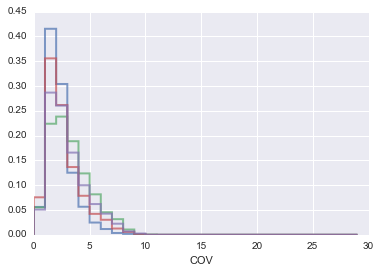

In [462]:
fig,ax = plt.subplots()
ax.hist(cov_NS.cov_VISp.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_VISp.cov)+1./len(cov_NS.cov_VISp.cov));
ax.hist(cov_NS.cov_VISpm.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_VISpm.cov)+1./len(cov_NS.cov_VISpm.cov));
ax.hist(cov_NS.cov_VISl.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_VISl.cov)+1./len(cov_NS.cov_VISl.cov));
ax.hist(cov_NS.cov_VISal.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_VISal.cov)+1./len(cov_NS.cov_VISal.cov));

ax.set_xlabel('COV')

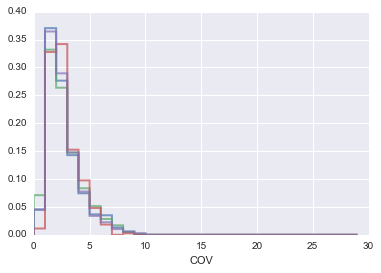

In [463]:
fig,ax = plt.subplots()
ax.hist(cov_NS.cov_Rbp4.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_Rbp4.cov)+1./len(cov_NS.cov_Rbp4.cov));
ax.hist(cov_NS.cov_Cux2.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_Cux2.cov)+1./len(cov_NS.cov_Cux2.cov));
ax.hist(cov_NS.cov_Scnn1a.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_Scnn1a.cov)+1./len(cov_NS.cov_Scnn1a.cov));
ax.hist(cov_NS.cov_Rorb.cov,bins=np.arange(0,30),alpha=0.7,linewidth=2,histtype='step',weights=np.zeros_like(cov_NS.cov_Rorb.cov)+1./len(cov_NS.cov_Rorb.cov));

ax.set_xlabel('COV')